# Empirical Timestep Distributions

This notebook visualizes the sampling strategies defined in `train.py` for the Flow Matching context (continuous $t \in [0, 1]$).

**Conventions:**
* $t=0$: Noise
* $t=1$: Data

In [11]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuration
N_SAMPLES = 100000
DEVICE = "cpu"

# Helper function to simulate batch sampling
def get_samples(strategy, n_samples):
    B = n_samples
    
    if strategy == "uniform":
        # train.py: sampled_t_input = torch.rand((B,), device=self.device)
        return torch.rand((B,), device=DEVICE)
        
    elif strategy == "ln":
        # train.py: z = torch.randn((B,), device=self.device); t_float = torch.sigmoid(z)
        z = torch.randn((B,), device=DEVICE)
        return torch.sigmoid(z)
        
    elif strategy == "bernoulli":
        # train.py logic:
        # Zone A: [0, 0.2) with prob 0.1
        # Zone B: [0.2, 1.0] with prob 0.9
        
        zone_mask = torch.rand((B,), device=DEVICE) < 0.9  # True = Zone B (80%)
        t_vals = torch.empty((B,), device=DEVICE)
        
        # Fill Zone B [0.2, 1.0] -> width 0.8, start 0.2
        if zone_mask.sum() > 0:
            t_vals[zone_mask] = (torch.rand(zone_mask.sum(), device=DEVICE) * 0.8) + 0.2
        
        # Fill Zone A [0.0, 0.2) -> width 0.2, start 0.0
        if (~zone_mask).sum() > 0:
            t_vals[~zone_mask] = (torch.rand((~zone_mask).sum(), device=DEVICE) * 0.2)
            
        return t_vals

    elif strategy == "beta_noise":
        # Biased towards t=0 (Noise)
        # train.py: alpha=0.8, beta=1.0
        dist = torch.distributions.Beta(
            torch.tensor([0.8], device=DEVICE), 
            torch.tensor([1.0], device=DEVICE)
        )
        return dist.sample((B,)).squeeze(-1)

    elif strategy == "beta_data":
        # Biased towards t=1 (Data)
        # train.py: alpha=1.0, beta=0.8
        dist = torch.distributions.Beta(
            torch.tensor([1.0], device=DEVICE), 
            torch.tensor([0.8], device=DEVICE)
        )
        return dist.sample((B,)).squeeze(-1)
    
    return torch.tensor([])

In [12]:
strategies = ["uniform", "ln", "bernoulli", "beta_noise", "beta_data"]
samples_dict = {}

print(f"Generating {N_SAMPLES} samples for each strategy...")
for s in strategies:
    samples_dict[s] = get_samples(s, N_SAMPLES).numpy()
    print(f"Finished {s}")

Generating 100000 samples for each strategy...
Finished uniform
Finished ln
Finished bernoulli
Finished beta_noise
Finished beta_data


## Combined Density Plot

<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_1664135/906229.py:6: SyntaxWarning: invalid escape sequence '\i'
  plt.title("Comparison of Sampling Strategies (Continuous $t \in [0, 1]$)", fontsize=16)


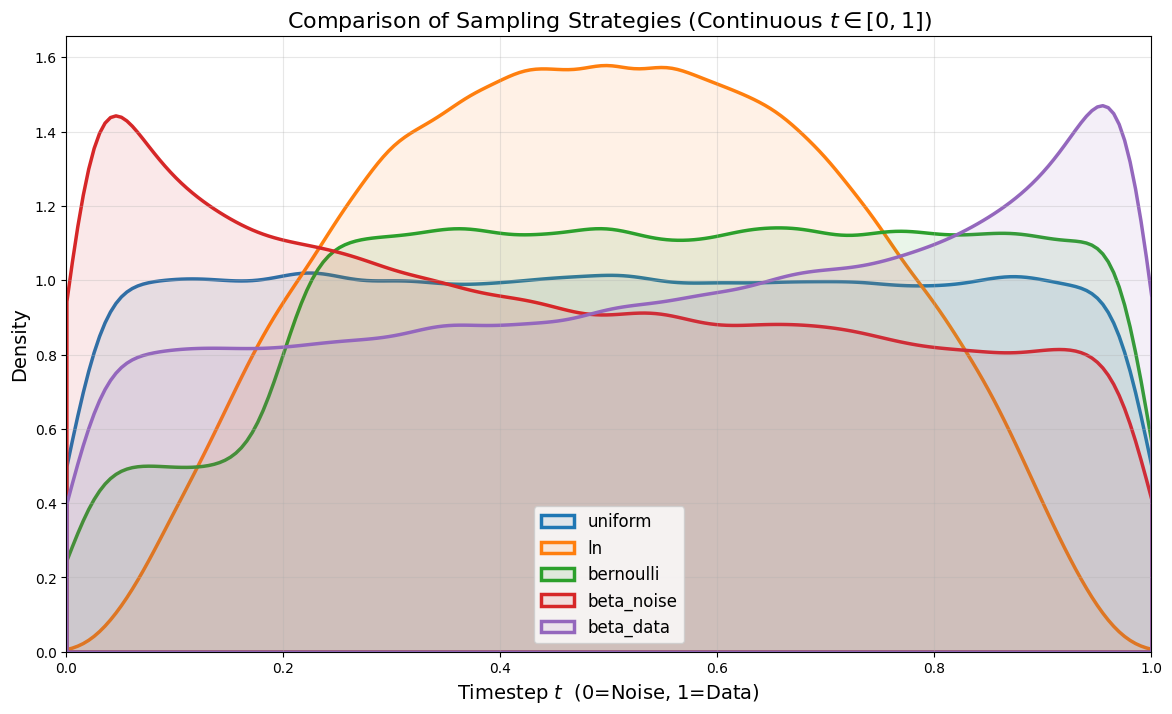

In [ ]:
plt.figure(figsize=(14, 8))

for name, samples in samples_dict.items():
    sns.kdeplot(samples, label=name, clip=(0, 1), fill=True, alpha=0.1, linewidth=2.5)

plt.title("Comparison of Sampling Strategies (Continuous $t \in [0, 1]$)", fontsize=16)
plt.xlabel("Timestep $t$  (0=Noise, 1=Data)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(0, 1)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## Individual Histograms 

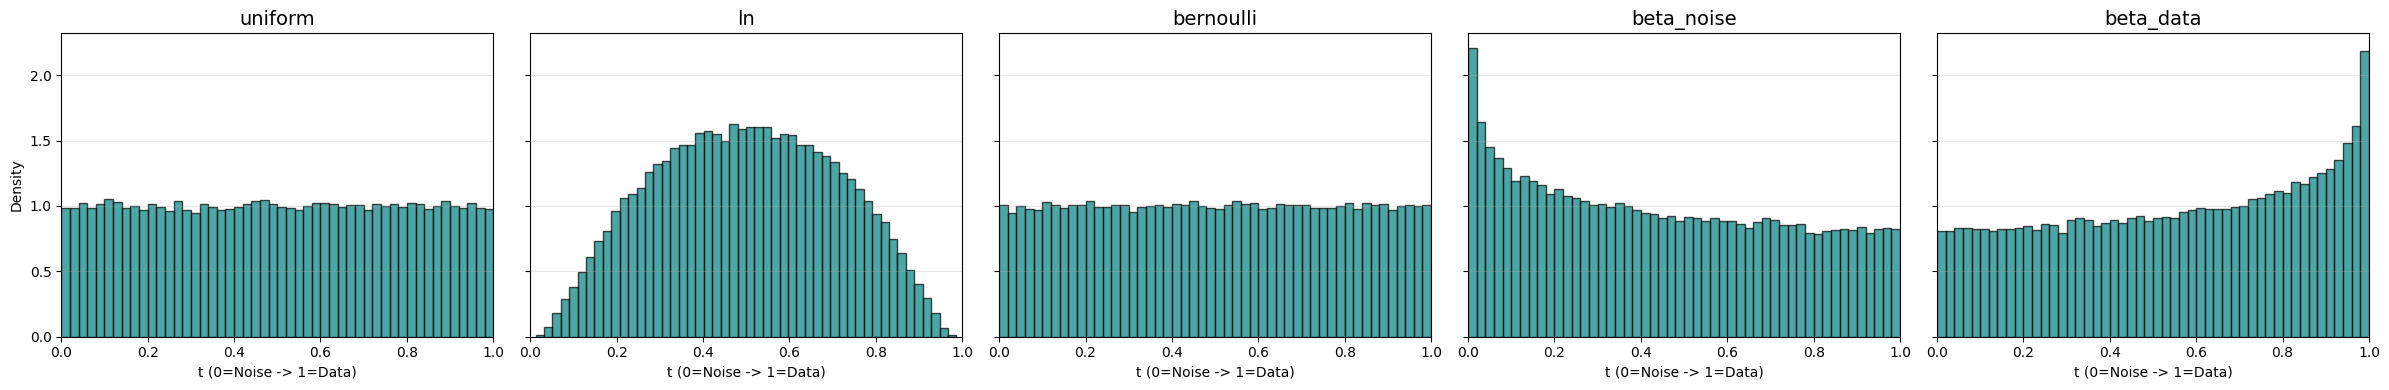

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(24, 4), sharey=True)

for i, (name, samples) in enumerate(samples_dict.items()):
    ax = axes[i]
    ax.hist(samples, bins=50, density=True, alpha=0.7, color='teal', edgecolor='black')
    ax.set_title(name, fontsize=14)
    ax.set_xlabel("t (0=Noise -> 1=Data)")
    ax.set_xlim(0, 1)
    ax.grid(axis='y', alpha=0.3)

axes[0].set_ylabel("Density")
plt.tight_layout()
plt.show()

<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:46: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1664135/203993925.py:46: SyntaxWarning: invalid escape sequence '\d'
  plt.axvline(t_delta_val, color='red', linestyle='--', label=f'Significant Interval ($t_\delta = {t_delta_val}$)')


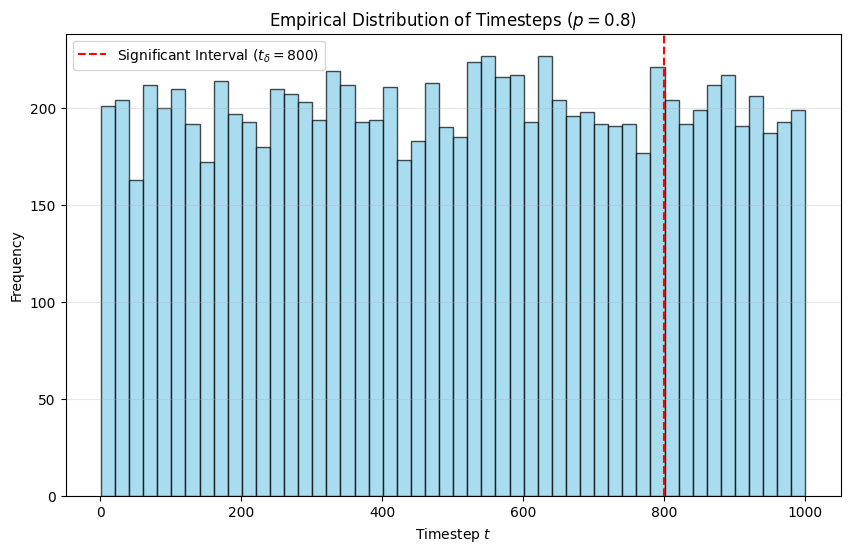

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def bernoulli_distribution_sampling(p, t_delta, t_T, num_samples=10000):
    """
    Implements the sampling logic from Algorithm 1.
    
    Args:
        p (float): Bernoulli parameter (probability of choosing the first interval).
        t_delta (int): The 'significant interval' threshold.
        t_T (int): The maximum timestep.
        num_samples (int): Number of iterations to simulate for the plot.
    """
    sampled_t = []

    for _ in range(num_samples):
        # Line 4: Generate random number u ~ U[0, 1]
        u = np.random.uniform(0, 1)
        
        # Line 5-9: Conditional sampling of timestep t
        if u < p:
            # Line 6: t ~ U({1, ..., t_delta})
            t = np.random.randint(1, t_delta + 1)
        else:
            # Line 8: t ~ U({t_delta, ..., t_T})
            t = np.random.randint(t_delta, t_T + 1)
            
        sampled_t.append(t)
        
        # Note: Lines 10-11 (gradient descent) are omitted as they 
        # require a specific model and dataset to execute.
        
    return np.array(sampled_t)

# --- Parameters ---
p_val = 0.8        # 70% chance to pick the lower interval
t_delta_val = 800  # Boundary
t_T_val = 1000     # Max range

# Generate data
samples = bernoulli_distribution_sampling(p_val, t_delta_val, t_T_val)

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(t_delta_val, color='red', linestyle='--', label=f'Significant Interval ($t_\delta = {t_delta_val}$)')
plt.title(f'Empirical Distribution of Timesteps ($p={p_val}$)')
plt.xlabel('Timestep $t$')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()